In [1]:
import os
import sys
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from model_settings import ms
from df_collector import df_collector
from feature_collector import preprocess_data
root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)
df_collector.root = Path().resolve().parent.parent
ds = time.time()
dataset = df_collector.cboe_spx_barriers().iloc[:,1:]
dataset = dataset[dataset['barrier_price']<dataset['spot_price']].reset_index(drop=True)
dataset['observed_price'] = np.maximum(dataset['barrier_price'] + np.random.normal(scale=(0.15)**2,size=dataset.shape[0]),0)
de = time.time()
print(de-ds)

24.10193419456482


In [2]:
dataset

,spot_price,strike_price,barrier,days_to_maturity,updown,outin,w,barrier_type_name,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,calculation_date,date,barrier_price,observed_price
0,4270.0,3843.00,2135.00,60.0,Down,Out,call,DownOut,0.0,0.0,0.04,0.101728,1.695111,-0.656127,1.138515,0.026595,2022-08-18 13:05:33.023,2022-08-19,477.666522,477.631954
1,4270.0,3843.00,2135.00,60.0,Down,Out,put,DownOut,0.0,0.0,0.04,0.101728,1.695111,-0.656127,1.138515,0.026595,2022-08-18 13:05:33.023,2022-08-19,25.082211,25.052376
2,4270.0,3843.00,2135.00,60.0,Down,In,call,DownIn,0.0,0.0,0.04,0.101728,1.695111,-0.656127,1.138515,0.026595,2022-08-18 13:05:33.023,2022-08-19,0.247859,0.253031
3,4270.0,3843.00,2135.00,60.0,Down,In,put,DownIn,0.0,0.0,0.04,0.101728,1.695111,-0.656127,1.138515,0.026595,2022-08-18 13:05:33.023,2022-08-19,0.372108,0.384813
4,4270.0,3843.00,2135.00,90.0,Down,Out,call,DownOut,0.0,0.0,0.04,0.101728,1.695111,-0.656127,1.138515,0.026595,2022-08-18 13:05:33.023,2022-08-19,507.407493,507.427247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21652735,5813.5,6394.85,8720.25,540.0,Up,In,put,UpIn,0.0,0.0,0.04,0.087499,1.982234,-0.657095,1.705566,0.018946,2024-10-15 16:50:04.131,2024-10-16,6.577341,6.581571
21652736,5813.5,6394.85,8720.25,720.0,Up,Out,call,UpOut,0.0,0.0,0.04,0.087499,1.982234,-0.657095,1.705566,0.018946,2024-10-15 16:50:04.131,2024-10-16,377.391470,377.445394
21652737,5813.5,6394.85,8720.25,720.0,Up,Out,put,UpOut,0.0,0.0,0.04,0.087499,1.982234,-0.657095,1.705566,0.018946,2024-10-15 16:50:04.131,2024-10-16,650.459798,650.490356
21652738,5813.5,6394.85,8720.25,720.0,Up,In,call,UpIn,0.0,0.0,0.04,0.087499,1.982234,-0.657095,1.705566,0.018946,2024-10-15 16:50:04.131,2024-10-16,189.459253,189.459153


In [3]:
dates = dataset['date'].copy().drop_duplicates().sort_values(ascending=False).reset_index(drop=True)
dates

0      2024-10-16
1      2024-10-15
2      2024-10-14
3      2024-10-12
4      2024-10-11
          ...    
597    2022-08-24
598    2022-08-23
599    2022-08-22
600    2022-08-20
601    2022-08-19
Name: date, Length: 602, dtype: object

151 451


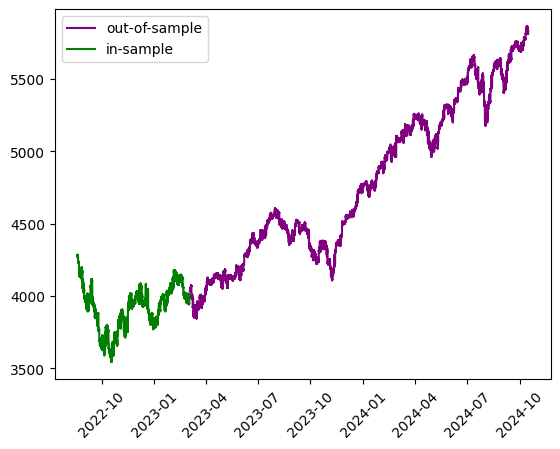

In [4]:
from convsklearn import barrier_trainer, asian_trainer
trainer = barrier_trainer
development_dates = dates.iloc[-len(dates)//4:]
test_dates = dates[~dates.isin(development_dates)]
print(len(development_dates),len(test_dates))
preprocessed = preprocess_data(dataset,development_dates,test_dates,trainer)
preprocessor = preprocessed['preprocessor']
test_data = preprocessed['test_data']
train_data = preprocessed['train_data']
train_test = preprocessed['train_test_arrays']
train_X = train_test['train_X']
train_y = train_test['train_y']
test_X = train_test['test_X']
test_y = train_test['test_y']

## stacked regressor

In [5]:
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer, PowerTransformer,FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
trainer.dnn_params

{'alpha': 0.01,
 'hidden_layer_sizes': (13, 13),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.1,
 'solver': 'sgd',
 'early_stopping': False,
 'max_iter': 500,
 'warm_start': True,
 'tol': 0.0001}

In [6]:
train_data.describe()

,spot_price,strike_price,barrier,days_to_maturity,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,barrier_price,observed_price
count,5.268420e+06,5.268420e+06,5.268420e+06,5.268420e+06,5268420.0,5268420.0,5.268420e+06,5.268420e+06,5.268420e+06,5.268420e+06,5.268420e+06,5.268420e+06,5.268420e+06,5.268420e+06
mean,3.922521e+03,3.922521e+03,3.924985e+03,3.249156e+02,0.0,0.0,4.000000e-02,3.835843e-01,2.439881e+01,-4.973977e-01,2.407290e+00,5.291461e-02,1.670347e+02,1.670351e+02
std,1.521244e+02,2.955458e+02,1.219641e+03,2.414911e+02,0.0,0.0,5.759282e-16,4.661786e+00,4.368708e+01,1.128473e-01,1.432645e+00,4.101372e-02,2.137752e+02,2.137749e+02
min,3.543750e+03,3.189375e+03,1.771875e+03,6.000000e+01,0.0,0.0,4.000000e-02,8.438163e-10,7.762052e-08,-7.644340e-01,1.000921e+00,4.400457e-11,0.000000e+00,0.000000e+00
25%,3.828250e+03,3.694787e+03,2.944054e+03,9.000000e+01,0.0,0.0,4.000000e-02,5.335102e-02,2.181435e+00,-5.838412e-01,1.399857e+00,2.690295e-02,1.093008e+01,1.093173e+01
50%,3.950750e+03,3.917550e+03,3.942535e+03,1.800000e+02,0.0,0.0,4.000000e-02,6.712009e-02,5.262529e+00,-5.031224e-01,1.847953e+00,4.529091e-02,8.741191e+01,8.741044e+01
75%,4.024500e+03,4.147500e+03,4.953799e+03,5.400000e+02,0.0,0.0,4.000000e-02,8.739796e-02,2.284760e+01,-4.118442e-01,2.933258e+00,7.482348e-02,2.649132e+02,2.649118e+02
max,4.285500e+03,4.714050e+03,6.428250e+03,7.200000e+02,0.0,0.0,4.000000e-02,2.309785e+02,3.640252e+02,-1.610633e-01,9.495520e+00,2.439533e-01,3.657950e+03,3.657936e+03


In [7]:
numerical_scaler = StandardScaler()
linear_contributors = [
    'spot_price', 'strike_price', 'days_to_maturity', 
    'risk_free_rate', 'dividend_rate', 
    # 'barrier',
    'v0',
    # 'theta',
    # 'kappa',
]

ridge_preprocessor = ColumnTransformer(
    transformers=[('scaling', numerical_scaler,linear_contributors)]
)
test_ridge_pipeline = make_pipeline(ridge_preprocessor, Ridge())


test_ridge = TransformedTargetRegressor(
    regressor=test_ridge_pipeline,
    transformer=numerical_scaler
)

test_ridge_fit = test_ridge.fit(train_X,train_y)

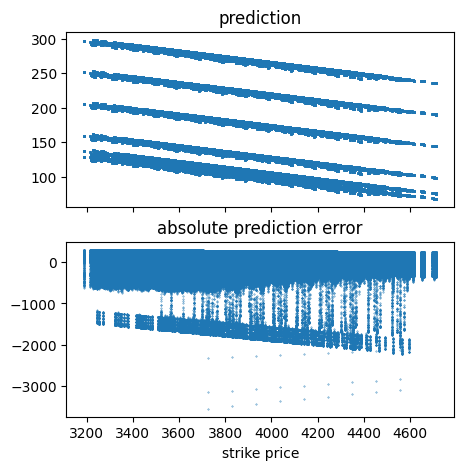


train spots:
calculation_date
2022-08-18 13:05:33.023    3543.75
2022-08-18 16:13:27.792    3544.75
2022-08-18 16:13:27.792    3570.00
2022-08-18 15:59:40.244    3578.00
2022-08-18 16:11:26.791    3578.25
                            ...   
2023-03-02 12:25:55.490    4283.50
2023-03-02 13:25:59.859    4283.75
2023-03-02 13:33:12.745    4284.25
2023-03-02 13:23:51.596    4284.50
2023-03-02 13:24:02.081    4285.50
Name: spot_price, Length: 1494, dtype: float64


TransformedTargetRegressor(regressor=Pipeline(steps=[('columntransformer',
                                                      ColumnTransformer(transformers=[('scaling',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'v0'])])),
                                                     ('ridge', Ridge())]),
                           transformer=StandardScaler())

In [8]:
K = train_X['strike_price'].squeeze().reset_index(drop=True).to_numpy()

predictions = test_ridge_fit.predict(train_X)
diff = predictions-train_y
fig,axs = plt.subplots(2,figsize=(5,5),sharex=True)
axs[0].scatter(K,predictions,s=0.1)
axs[0].set_title('prediction')
axs[1].scatter(K,diff,s=0.1)
axs[1].set_title('absolute prediction error')
plt.xlabel('strike price')
plt.show()
spots = train_data['spot_price'].copy().squeeze().sort_values().reset_index(drop=True)
spots.index = train_data['calculation_date']
print(f"\ntrain spots:\n{spots.drop_duplicates()}")
test_ridge

In [11]:
mlp_pipeline = make_pipeline(preprocessor,MLPRegressor(**trainer.dnn_params))

ridge_pipeline = make_pipeline(ridge_preprocessor, Ridge())

stacked_regressor = StackingRegressor(
    estimators=[
        ('dnn',mlp_pipeline),
        ('ridge',ridge_pipeline)

    ],
    final_estimator=RidgeCV()
)
meta = TransformedTargetRegressor(regressor=stacked_regressor,transformer=numerical_scaler)
meta

TransformedTargetRegressor(regressor=StackingRegressor(estimators=[('dnn',
                                                                    Pipeline(steps=[('columntransformer',
                                                                                     ColumnTransformer(transformers=[('StandardScaler',
                                                                                                                      StandardScaler(),
                                                                                                                      ['spot_price',
                                                                                                                       'strike_price',
                                                                                                                       'days_to_maturity',
                                                                                                                       'risk_free_rate',
                                                                                                                       'dividend_rate',
                                                                                                                       'kappa',
                                                                                                                       'theta',
                                                                                                                       'rho',
                                                                                                                       'eta',
                                                                                                                       'v0',
                                                                                                                       'barrier']),
                                                                                                                     ('OneHotEncoder',
                                                                                                                      OneHotEncoder(sparse_output=F...
                                                                                                  learning_rate='adaptive',
                                                                                                  learning_rate_init=0.1,
                                                                                                  max_iter=500,
                                                                                                  solver='sgd',
                                                                                                  warm_start=True))])),
                                                                   ('ridge',
                                                                    Pipeline(steps=[('columntransformer',
                                                                                     ColumnTransformer(transformers=[('scaling',
                                                                                                                      StandardScaler(),
                                                                                                                      ['spot_price',
                                                                                                                       'strike_price',
                                                                                                                       'days_to_maturity',
                                                                                                                       'risk_free_rate',
                                                                                                                       'dividend_rate',
                                                                                                  

In [ ]:
meta.fit(train_X,train_y)
P = meta.predict(train_X)
diff = train_y - P
RMSE = np.sqrt(np.mean(diff**2))
MAE = np.mean(np.abs(diff))
end = time.time()
runtime = end-train_start
print(f"cpu: {runtime}")
print(f"\n\nMAE: {MAE}\nRMSE: {RMSE}")

In [ ]:
testP = meta.predict(test_X)
diff = test_y - testP
RMSE = np.sqrt(np.mean(diff**2))
MAE = np.mean(np.abs(diff))
print(f"MAE: {MAE}\nRMSE: {RMSE}")

### versus original

In [ ]:
dnn = barrier_trainer.run_dnn(preprocessor, train_X, train_y)
P = dnn.predict(train_X)
diff = train_y - P
RMSE = np.sqrt(np.mean(diff**2))
MAE = np.mean(np.abs(diff))
print(f"\n\nin sample:\nMAE: {MAE}\nRMSE: {RMSE}")

In [ ]:
testP = dnn.predict(test_X)
diff = test_y - testP
RMSE = np.sqrt(np.mean(diff**2))
MAE = np.mean(np.abs(diff))
print(f"MAE: {MAE}\nRMSE: {RMSE}")

In [ ]:
train_data.describe()